In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 165 (delta 71), reused 130 (delta 47), pack-reused 0
Receiving objects: 100% (165/165), 27.60 MiB | 33.72 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=13096 sha256=4ae16ca71305af0f3bf107c6e6183e41e622e40d0822ff0a4c8bc52c1786e9c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-0xdi66ta/wheels/55/59/29/0fb1c63565215773

In [2]:
!pip install scikit-learn

  Using cached scikit_learn-1.0.1-cp39-cp39-macosx_10_13_x86_64.whl (8.0 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)


In [1]:
from dul_2021.utils.pr3_utils import *
from dul_2021.utils.hw4_utils import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt

from torch.distributions import MultivariateNormal
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

from tqdm.auto import tqdm

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# !pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import torchdiffeq

# Question 1: 2D Data


Dataset 1


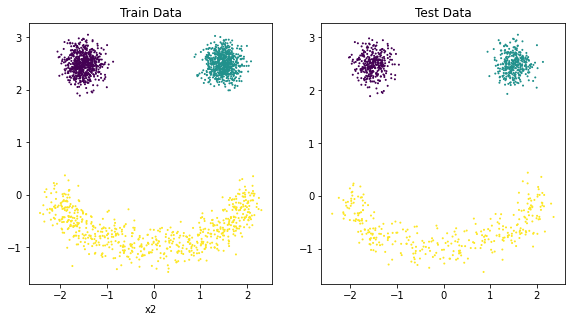

Dataset 2


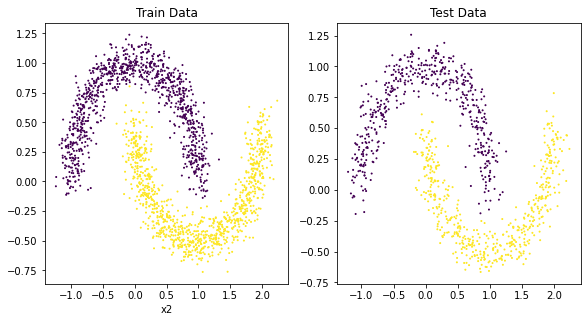

In [9]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial z} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [10]:
@torch.no_grad()
def test_epoch(model, dl, t):
    loss = 0.
    for batch in tqdm(dl, leave=False, desc='Testing'):
        batch = batch.to(device)
        loss -= model.log_prob(batch, t).mean()
    
    return (loss / len(dl)).item()


def train_epoch(model, optimizer, dl, loss_acc, t: tuple[float, float]):
    bar = tqdm(dl, leave=False, desc='Training')
    for batch in bar:
        batch = batch.to(device)
        
        loss = -model.log_prob(batch, t).mean()
        bar.set_postfix_str(f'loss = {loss.item():.5f}')
        loss_acc.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
#         utils.clip_grad_norm_(model.parameters(), 2.)
        optimizer.step()


def train(model, optimizer, train_dl, test_dl, t: tuple[float, float], epochs=10):
    train_losses = []
    test_losses = [test_epoch(model, test_dl, t)]
    
    range_bar = tqdm(range(epochs), desc='Epoch')
    for ep in range_bar:
        train_epoch(model, optimizer, train_dl, train_losses, t)
        
        loss = test_epoch(model, test_dl, t)
        test_losses.append(loss)
        range_bar.set_postfix_str(f'test_loss = {loss:.5f}')
        
    return train_losses, test_losses

In [11]:
class HyperNet(nn.Module):
    def __init__(self, io_size, hidden_size, width):
        super().__init__()
        self.io_size = io_size
        self.block_size = io_size * width
        self.width = width
        self.seq = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 3 * self.block_size + width)
        )
        
    def forward(self, t):
        out = self.seq(t)
        u, w, g, b = out.split([self.block_size] * 3 + [self.width], dim=1)
        u = u * g.sigmoid()
        return (
            w.reshape(self.width, self.io_size, 1), 
            b.reshape(self.width, 1, 1), 
            u.reshape(self.width, 1, self.io_size)
        )
    
    
class CNF(nn.Module):
    def __init__(self, io_size, hidden_size, width, tol=1e-5):
        super().__init__()
        self.tol = tol
        self._net = HyperNet(io_size, hidden_size, width)
        
        self._dist = MultivariateNormal(
            torch.zeros(io_size, device=device),
            torch.eye(io_size, device=device)
        )
        
    @staticmethod
    def _trace_df_dz(f, z):
        """
        Calculates the trace of the Jacobian df/dz.
        Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
        """
        sum_diag = 0.
        for i in range(z.shape[1]):
            sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

        return sum_diag.view(-1, 1).contiguous()
        
    @torch.enable_grad()
    def forward(self, t, states):
        z, logp_z = states
        
        z.requires_grad_(True)
        
        w, b, u = self._net(t.view(1, 1))
        
        z_ = z[None].repeat(self._net.width, 1, 1)
        
#         print(u.size())
        
#         print((z_ @ w).size())
#         print((z_ @ w + b).size())
#         print(((z_ @ w + b).tanh() @ u).size())
        dz_dt = ((z_ @ w + b).tanh() @ u).mean(0)
        
        dlogp_z_dt = -self._trace_df_dz(dz_dt, z)
        
        return dz_dt, dlogp_z_dt
        
    def flow(self, z1: torch.Tensor, t: tuple[float, float]):
        dlogp_dt = z1.new_zeros(z1.size(0), 1)
        time = z1.new_tensor(t[::-1])
        
#         print(dlogp_dt.dtype, time.dtype, z1.dtype)
        
#         print(z1.size(), dlogp_dt.size())
        
        zt, logp_dt = odeint(
            self,
            (z1, dlogp_dt),
            time,
            atol=self.tol,
            rtol=self.tol,
            method="dopri5"
        )
#         print('ode', zt.size(), logp_dt.size())
        return zt[-1], logp_dt[-1]
        
        
    def log_prob(self, batch, t: tuple[float, float]):
        zt0, logp_dt0 = self.flow(batch, t)
        
        logpx = self._dist.log_prob(zt0) - logp_dt0.ravel()
        
        return logpx
    
    
    @torch.no_grad()
    def encode(self, batch, t):
        return self.flow(batch, t)[0].cpu().numpy()

In [12]:
def q1(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
    """
    model = CNF(train_data.shape[1], hidden_size=32, width=64).to(device)
    optim = opt.Adam(model.parameters(), lr=1e-3)
    
    train_dl = data.DataLoader(train_data.astype(np.float32), batch_size=128, shuffle=True)
    test_dl = data.DataLoader(test_data.astype(np.float32), batch_size=128, shuffle=False)
    
    t = (0., 10.)

    train_losses, test_losses = train(model, optim, train_dl, test_dl, t, 100)
    

    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
        
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy), slice(x_lim[0], x_lim[1] + dx, dx)]
    
    mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
#     print(mesh_xs.size())
#     print(train_data.shape)
    
    
    with torch.no_grad():
        mesh_dl = data.DataLoader(mesh_xs, batch_size=512)

        densities = np.hstack(
            [np.exp(model.log_prob(batch.to(device), t).cpu().detach().numpy()) for batch in tqdm(mesh_dl, desc='mesh', leave=False)]
        )

        train_dl = data.DataLoader(train_data.astype(np.float32), batch_size=512)
        latents = np.vstack(
            [model.encode(batch.to(device), t) for batch in tqdm(train_dl, desc='latents', leave=False)]
        )
    
    return train_losses, test_losses, densities, latents


### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

mesh:   0%|          | 0/202 [00:00<?, ?it/s]

latents:   0%|          | 0/4 [00:00<?, ?it/s]

Final Test Loss: 1.3267


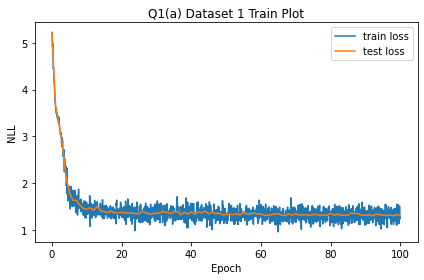

/Users/dmitry/PycharmProjects/hse_dul/Homework/hw4/dul_2021/utils/pr3_utils.py:111: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
/Users/dmitry/PycharmProjects/hse_dul/Homework/hw4/dul_2021/utils/pr3_utils.py:112: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))


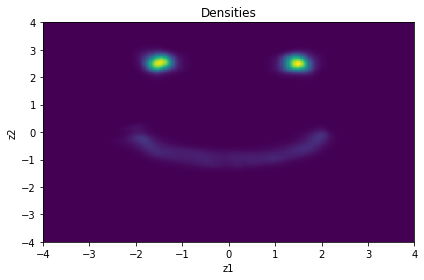

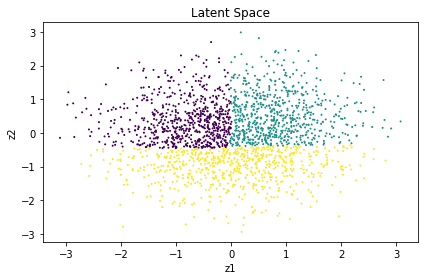

In [45]:
q1_save_results(1, 'a', q1)

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Testing:   0%|          | 0/8 [00:00<?, ?it/s]

mesh:   0%|          | 0/32 [00:00<?, ?it/s]

latents:   0%|          | 0/4 [00:00<?, ?it/s]

Final Test Loss: 1.0633


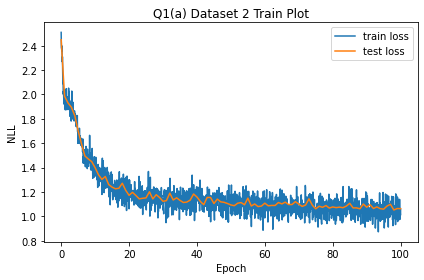

/Users/dmitry/PycharmProjects/hse_dul/Homework/hw4/dul_2021/utils/pr3_utils.py:111: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
/Users/dmitry/PycharmProjects/hse_dul/Homework/hw4/dul_2021/utils/pr3_utils.py:112: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))


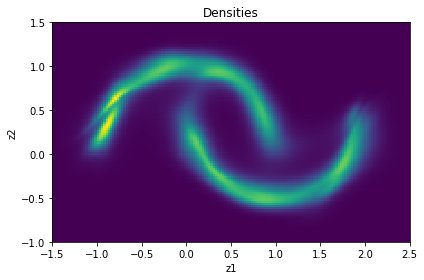

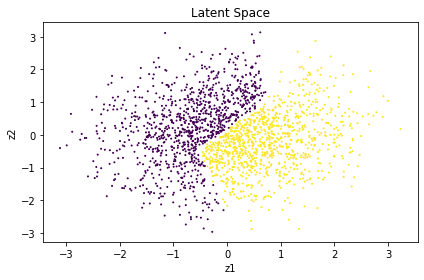

In [46]:
q1_save_results(2, 'a', q1)

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [62]:
class HTECNF(CNF):
    @staticmethod
    def _trace_df_dz(f, z, n=10):
        trace = z.new_zeros(z.size(0))
        for _ in range(n):
            v = 2 * torch.randint(0, 2, z.size(), dtype=torch.float, device=device) - 1
#             print(f.size(), v.size())
            A = torch.autograd.grad((v * f).sum(), z, create_graph=True)[0]
#             print(A.size(), v.size())
#             print((A*v).size())
            trace += (A * v).sum(1)
        trace /= n
        return trace.view(-1, 1)

In [63]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """
    
    model = HTECNF(train_data.shape[1], hidden_size=32, width=64, tol=1e-2).to(device)
    optim = opt.Adam(model.parameters(), lr=1e-3)
    
    train_dl = data.DataLoader(train_data.astype(np.float32), batch_size=128, shuffle=True)
    test_dl = data.DataLoader(test_data.astype(np.float32), batch_size=128, shuffle=False)
    
    t = (0., 10.)

    train_losses, test_losses = train(model, optim, train_dl, test_dl, t, 20)
    
    return train_losses, test_losses

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Testing:   0%|          | 0/5 [00:00<?, ?it/s]

Final Test Loss: 12.1315


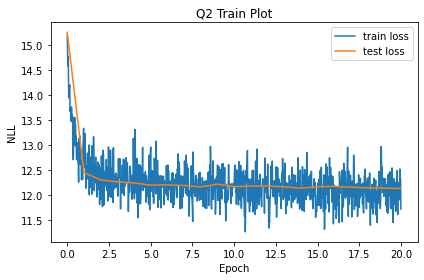

In [64]:
q2_save_results(q2)

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b3(train_data, test_data):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """

    """ YOUR CODE HERE """


### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(b3)